In [5]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_val_score
from skorch import NeuralNetClassifier
from torch.utils.data import random_split
from skorch.helper import SliceDataset
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid

import torch.nn as nn
import torch.nn.functional as F

import torchvision.transforms as transforms
import torchvision.datasets as datasets

Length of Train Data : 1139
Length of Validation Data : 284
[2 0 3 ... 0 0 2]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


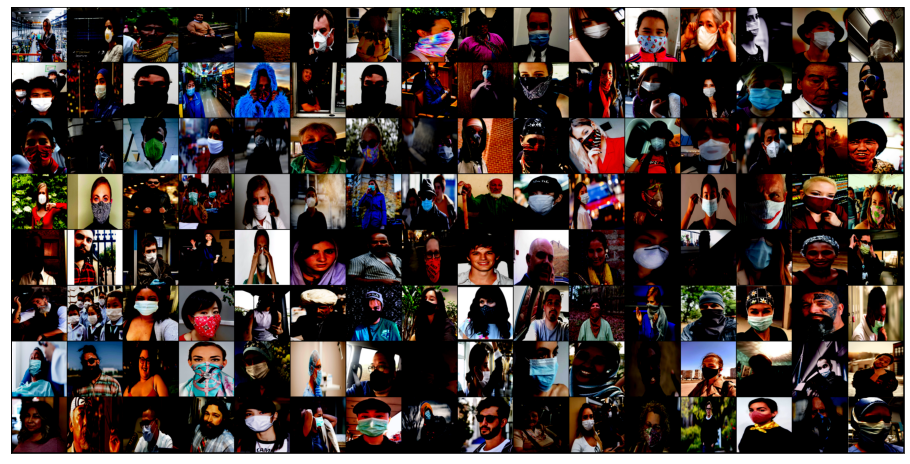

In [20]:
device = torch.device("cpu")


#normalizing
transform = transforms.Compose([
    transforms.Resize((150,150)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

all_dataset = datasets.ImageFolder(
    root='input/masks/train',transform = transform)

m = len(all_dataset)
batch_size = 128

train_data,val_data = random_split(all_dataset,[int(m - m * 0.2)+1, int(m * 0.2)])
print(f"Length of Train Data : {len(train_data)}")
print(f"Length of Validation Data : {len(val_data)}")

#load the train and validation into batches.
train_dl = DataLoader(train_data, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_data, batch_size*2, num_workers = 4, pin_memory = True)

y_train = np.array([y for x, y in iter(train_data)])

print(y_train)


def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break
        
show_batch(train_dl)    

class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        

class NaturalSceneClassification(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32,64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        
            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128 ,128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(256,256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Flatten(),
            nn.Linear(82944,1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512,4)
        )
    
    def forward(self, xb):
        return self.network(xb)
torch.manual_seed(42)

In [ ]:



num_epochs=15
lr=1e-4
opt_func = torch.optim.Adam
lr = 0.001
def plot_accuracies(history):
    """ Plot the history of accuracies"""
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
    
def plot_losses(history):
    """ Plot the losses in each epoch"""
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');


@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    
    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        
        model.train()
        train_losses = []
        
        for batch in train_loader:
            print("bacth..")
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    plot_accuracies(history)

    return history

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

  
    
@torch.no_grad()
def stats(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)    

history = fit(num_epochs, lr, convnet, train_dl, val_dl, opt_func)

stats(convnet,val_dl)
plot_accuracies(history)
plot_losses(history)


bacth..
bacth..
bacth..
bacth..
bacth..
bacth..
bacth..
bacth..
bacth..
Epoch [0], train_loss: 1.3614, val_loss: 1.3724, val_acc: 0.2344
bacth..
bacth..
bacth..
bacth..
bacth..
bacth..
bacth..
bacth..
bacth..
Epoch [1], train_loss: 1.3696, val_loss: 1.3661, val_acc: 0.3030
bacth..
bacth..
bacth..
bacth..
bacth..
bacth..
bacth..
bacth..
bacth..
Epoch [2], train_loss: 1.3628, val_loss: 1.3673, val_acc: 0.2344
bacth..
bacth..
bacth..
bacth..
bacth..
bacth..
bacth..
bacth..
bacth..
Epoch [3], train_loss: 1.3511, val_loss: 1.3517, val_acc: 0.2363
bacth..
bacth..
bacth..
bacth..
bacth..
bacth..
bacth..
bacth..
bacth..
Epoch [4], train_loss: 1.2884, val_loss: 1.2741, val_acc: 0.4230
bacth..
bacth..
bacth..
bacth..
bacth..
bacth..
bacth..
bacth..
bacth..
Epoch [5], train_loss: 1.2213, val_loss: 1.2180, val_acc: 0.4414
bacth..
bacth..
bacth..
bacth..
bacth..
bacth..
bacth..
bacth..
bacth..
Epoch [6], train_loss: 1.1428, val_loss: 1.2653, val_acc: 0.3917
bacth..
bacth..
bacth..
bacth..
bacth..
b

In [ ]:


result = evaluate(val_dl)

In [ ]:
for p in result:
    
    print(dataset.classes[p.item()])

In [ ]:
show_batch(val_dl)    